In [1]:
%load_ext ipycache

In [2]:
# import core packages
import io
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image
import itertools
import json
import multiprocessing as mul
import requests
from zipfile import ZipFile

# import third party dependencies
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot

# initialize plotly to use offline mode
init_notebook_mode(connected=True)

# adjust the notebook to print everything in the cell
InteractiveShell.ast_node_interactivity = 'all'

### The goal
Throughout this notebook I will show that a clear bias exists in the Wikipedia dataset. Specifically, we will discuss the bias in terms of politician coverage through number and quality of the articles in relation to their home countries population. We will gather the data from two sources: one will be our source for population data and the other contains the relevant article metadata. For each article, we will query a machine learning service to estimate the quality of the article. And finally, we will generate a few tables and visualizations to display the bias.

### Data Load

#### Wikipedia Articles -  [Figshare](https://figshare.com/articles/Untitled_Item/5513449)
This dataset contains the article metadata we need to estimate the number and quality of articles within a given country. I download the data directly to this notebook, extract the compressed file contents, and stream directly into a Pandas DataFrame.

In [3]:
# download the data from figshare
figshare = 'https://ndownloader.figshare.com/files/9614893'
r = requests.get(figshare)

# make sure the result is valid
if r.ok:
    # feed a byte stream into a ZipFile
    stream = io.BytesIO(r.content)
    zf = ZipFile(stream)
    
    # locate the csv file within the list of files embedded in the ZipFile generated above
    # I make sure to not include the files within the 'MAX OS' directory
    file = [
        f for f in zf.filelist if f.filename.find('page_data.csv') > 0 and f.filename.find('MAC') == -1
    ][0]
    
    # extract the csv file and read into a pandas dataframe
    page_data = pd.read_csv(zf.extract(file))

# print this if the request failed for some reason
else:
    print(f'failed to download page data: {r.status}')

page_data.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


#### Population Data - [DropBox](https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0) location.
This is a random DropBox location provided for the assignment. It contains each country and their population estimated at some point in the middle of 2018. Again, I download the file directly from DropBox and feed the resulting byte stream into a Pandas DataFrame.

In [4]:
# download the data from Drop Box
dropbox = 'https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=1'
r = requests.get(dropbox)

# make sure the result is valid
if r.ok:
    # this time, feed the csv byte stream into a pandas dataframe directly
    stream = io.BytesIO(r.content)
    pop = pd.read_csv(stream)

# print this if the request failed for some reason
else:
    print(f'failed to download population data: {r.status}')

pop.head()

,Geography,Population mid-2018 (millions)
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


Right at the start we see inconsistencies in the format of our joining keys - Geography and country. I run some quick string tools to ensure they're consistent through both datasets. The columns are renamed in order to make the joining easier to read. Additionally, I verify that the joining keys are, in fact, keys then perform an inner join to include only the countries that have data in both sets.

In [5]:
# explicitly rename the columns
pop.rename(columns={
    'Geography':'country',
    'Population mid-2018 (millions)':'population'
}, inplace=True)

page_data.rename(columns={
    'page':'article_name',
    'rev_id':'revision_id'
}, inplace=True)

# enforce string format consistency
pop.country = pop.country.apply(str.title)
page_data.country = page_data.country.apply(str.title)

# double check the 'keys' in each dataframe are in fact joinable keys by verifying uniqueness
assert len(pd.unique(pop.country)) == len(pop)
assert len(pd.unique([(t.article_name, t.country) for t in page_data.itertuples()])) == len(page_data)

# convert the population to a  float - I use replace to remove any commas in the string represenation
pop.population = pop.population.apply(lambda x: float(x.replace(',', '')))

# merge the data frames
df = pop.merge(page_data, on='country', how='inner')

df.head()

,country,population,article_name,revision_id
0,Algeria,42.7,Template:Algeria-politician-stub,544347736
1,Algeria,42.7,Template:Algeria-diplomat-stub,567620838
2,Algeria,42.7,Template:AlgerianPres,665948270
3,Algeria,42.7,Ali Fawzi Rebaine,686269631
4,Algeria,42.7,Ahmed Attaf,705910185


In [6]:
len(df)

45077

### Make API calls to get articles predictions
Now that we have the two datasets prepared and merged into one; we use the metadata to query the ORES machine learning service to get article quality estimates. There are over 45K revision ids in the dataset above. Because of this, I write a function to handle a single query and process them in parallel using a process pool.

In [7]:
def get_ores_data(revision_ids):    
    """Make an API call to ORES
    
    Args:
        revision_ids: [(str | int),]  list of revision ids to include with the query
        
    Returns:
        [(int, str),] A list of tuples containing two elements - [(revision_id, quality),]
    """
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - joining the revision IDs together separated by | marks.
    params = {
        'project': 'enwiki',
        'model': 'wp10',
        'revids': '|'.join(str(x) for x in revision_ids)
    }
    
    # make the call and verify the response before proceeding
    response = requests.get(endpoint.format(**params))
    if response.ok:
        # convert the response to json
        response = response.json()
        
        # return the scores as a list of tuples, taking only the prediction
        results = []
        for rid in revision_ids:
            # start at the parent node we're interested in
            parent = response['enwiki']['scores'][str(rid)]['wp10']

            # check for any errors, append either the error or  prediction
            if 'error' in parent.keys():
                results.append((rid, parent['error']['type']))
            else:
                results.append((rid, parent['score']['prediction']))
            
        return results
    
    # if the request failed, return the status code and list of revision ids so we can retry later
    else:
        return dict(err=response.status, revision_ids=revision_ids)

Process the revision ids in batches of 50 to preclude Wikimedia blocking the request. I also run these requests in parallel and cache the results. To force the cell to run again you can do one of two things: comment out the cell magic in line 1 or delete the cached pkl file.

In [8]:
%%cache api_results.pkl results

# define how many rev_ids to include in each API call
step = 50

# start a task pool using all available cores
pool = mul.Pool(mul.cpu_count())

# process the calls in parallel
results = list(pool.map(
    get_ores_data,
    [df.revision_id[i:i+step] for i in range(0, len(df), step)]
))

# make sure to kill the children
pool.close(); pool.join()

[Skipped the cell's code and loaded variables results from file 'C:\Users\lukew\OneDrive\School\DATA 512 [HCDS - Ethics]\DATA512_A2\api_results.pkl'.]


### Create the final dataset

I flatten the list of batched requests into a single list then convert them to a dataframe and join with the main.

In [9]:
# flatten the batches into a single list
results = list(itertools.chain.from_iterable(results))

# convert to a dataframe
results = pd.DataFrame(results, columns=['revision_id', 'prediction'])

# join with the main
df_ = df.merge(results, on='revision_id', how='inner')

# verify that each revision id was processed before resetting the variable
assert len(df) == len(df_)
df = df_; del df_

# persist the final dataframe  to disk
df.to_csv('data-512-a2.csv', index=None)

df.head()

,country,population,article_name,revision_id,prediction
0,Algeria,42.7,Template:Algeria-politician-stub,544347736,Stub
1,Algeria,42.7,Template:Algeria-diplomat-stub,567620838,Stub
2,Algeria,42.7,Template:AlgerianPres,665948270,Stub
3,Algeria,42.7,Ali Fawzi Rebaine,686269631,Stub
4,Algeria,42.7,Ahmed Attaf,705910185,Stub


### Analysis
I will create two tables to show the bias. One to answer the question regarding the number of articles of per country and the other for quality. The number of articles is calculated as a ratio over the population count in order to compare the countries. For quality, I create a ratio of the number of good articles or the total number of articles for the country.

In [10]:
# reset the population index to make the following computations more readable
pop.set_index('country', inplace=True)

# group the dataframe by country , count the number of articles in each
# additionally, reset the index inorder to collapse the dataframe back
# and finally, rename the prediction column to what it now represents
table12 = df.loc[:, ['country', 'prediction']]\
    .groupby(['country'])\
    .count()\
    .reset_index()\
    .rename(columns={'prediction':'num_articles'})

# calculate the articles per million as a new column
table12['articles_per_million'] = [
    np.round(t.num_articles/pop.loc[t.country].population, 1)
    for t in table12.itertuples()
]

# sort the table by the number of articles per million 
table12 = table12.sort_values(by='articles_per_million', ascending=False)

# extract the highest and lowest ten countries into separate dataframes
t1 = table12.drop(columns='num_articles').iloc[:10]
t2 = table12.drop(columns='num_articles').iloc[-10:]

t1; t2

,country,articles_per_million
166,Tuvalu,5500.0
115,Nauru,5300.0
135,San Marino,2733.3
108,Monaco,1000.0
93,Liechtenstein,725.0
161,Tonga,630.0
103,Marshall Islands,616.7
68,Iceland,515.0
3,Andorra,425.0
52,Federated States Of Micronesia,380.0


,country,articles_per_million
176,Vietnam,2.0
13,Bangladesh,1.9
159,Thailand,1.7
82,"Korea, North",1.5
178,Zambia,1.5
51,Ethiopia,1.0
173,Uzbekistan,0.9
34,China,0.8
70,Indonesia,0.8
69,India,0.7


Just from the number of articles we can see a very clear bias. The top two countries  are much higher than the remaining. Tuvalu and Nauru are tiny islands in the South Pacific with less than 15k people each. The remaining countries on the top ten list, besides Iceland, are tiny nation states in the Pacific or Europe. Conversely, we see densely populated and/or repressed countries in the bottom ten. The numbers in the table speak loudly giving a very wide range - (0.7, 5500). However, to drive the numbers home a bit more I show a boxplot of the values. Notice how extreme the top countries are as outliers. It is skewed so badly that you can only distinghish the top countries. Running the notebook rather than viewing it directly on GitHub lets you interact with the plot if you want to zoom into the dense region or hover to see which country each dot represents.

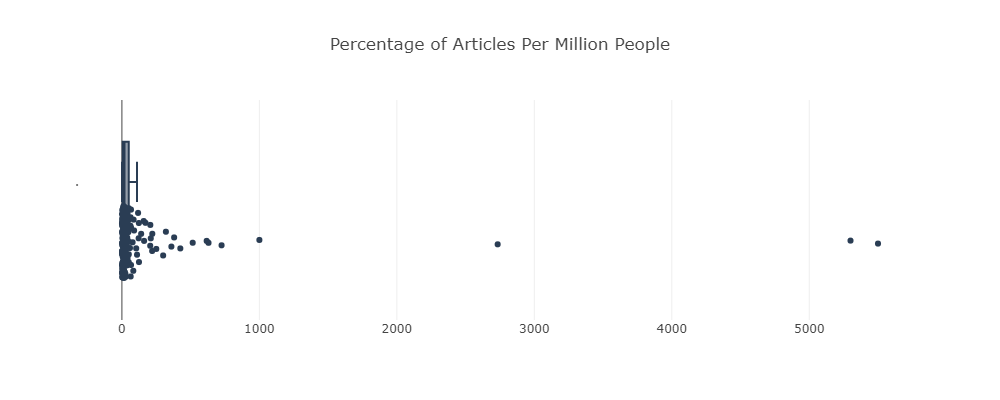

In [11]:
# create the first boxplot
h1 = go.Box(
    name='.', 
    x=table12.articles_per_million, 
    text=table12.country, 
    boxpoints='all', 
    jitter=.9, 
    xaxis='x1',
    marker=dict(color='#2A3D54')
)

# show the plot
fig = go.Figure(
    [h1],
    go.Layout(
        title='Percentage of Articles Per Million People',
        height=400,
        width=1000,
    ),
)

# write it to disk
pio.write_image(fig, 'hcds-a2-counts.png')

# because Plotly images do not display in GitHub, I use a byte stream to display 
# rather than the standard plotly iplot function
ibytes = pio.to_image(fig, format='png')
Image(ibytes)

# uncomment the next line to display the interactive plot
#iplot(fig)

Create the second table with a proportion of articles estimated as having high quality.

In [12]:
# first, extract only the articles deemed high quality by creating a mask 
# then, group by country and count the number of articles in each and reset the index
# rename the column to what it now represents
# finally, merge with table12 so we have the full count of articles in the same frame
table34 = df.loc[[p in ['GA', 'FA'] for p in df.prediction], ['country', 'prediction']]\
    .groupby(['country'])\
    .count()\
    .reset_index()\
    .rename(columns={'prediction':'num_quality_articles'})\
    .merge(
        table12.drop(columns='articles_per_million'),
        on='country'
    )

# calculate the percent of articles deemed high quality as a new column
table34['percent_quality'] = [
    np.round(t.num_quality_articles/t.num_articles, 3)
    for t in table34.itertuples()
]

# drop the unnecessary columns and sort by the percentage of quality articles
table34 = table34.drop(columns=['num_quality_articles', 'num_articles'])\
    .sort_values(by='percent_quality', ascending=False)

# extract the highest and lowest ten into new dataframes
t3 = table34.iloc[:10]
t4 = table34.iloc[-10:]

t3; t4

,country,percent_quality
65,"Korea, North",0.179
108,Saudi Arabia,0.134
22,Central African Republic,0.118
105,Romania,0.115
82,Mauritania,0.096
12,Bhutan,0.091
131,Tuvalu,0.091
32,Dominica,0.083
135,United States,0.075
11,Benin,0.074


,country,percent_quality
89,Namibia,0.006
111,Sierra Leone,0.006
16,Brazil,0.005
13,Bolivia,0.005
40,Fiji,0.005
87,Morocco,0.005
75,Lithuania,0.004
94,Nigeria,0.004
100,Peru,0.003
125,Tanzania,0.002


Again, we see an enormous disparity between the top and bottom ten countries. The most suprising thing to me was the quality of articles. We see that North Korea has only 1.5 articles per million people but of those articles, they have high percentage of good quality. I don't know who wrote these articles. Maybe the reason for such a high percentage is because the originating authors are from western sources  or this is a result of North Korean governance. Both are assumptions and it would be fun to explore with more data. The ten lowest quality do not necessarily suprise me. These are countries are neither English speaking or known to have great public education systems that would lead to high quality articles being written. Again, I show a boxplot to visualize the skew. This is more symmetric than the number of articles but still skewed. But the skew isn't the most interesting part, its the content and location of styles of governemnt within the list. Again, I'd like to align this dataset with the world indicators to bring out more interesting insights.

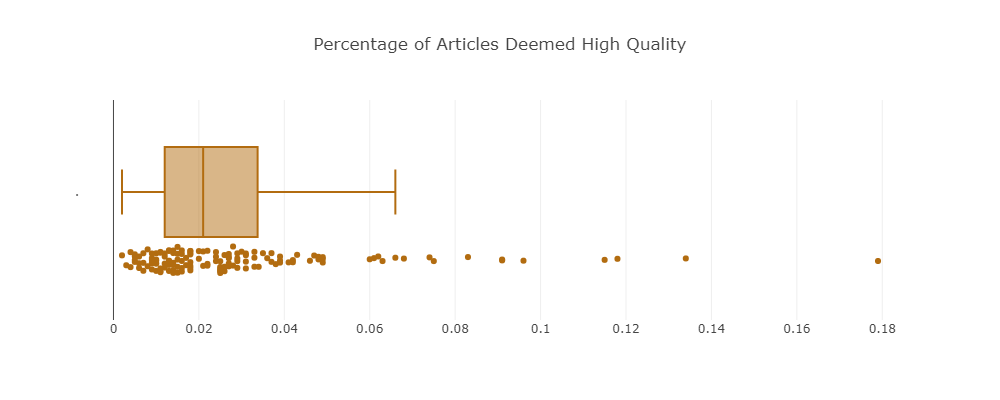

In [13]:
# create the second boxplot
h2 = go.Box(
    name='.', 
    x=table34.percent_quality, 
    text=table34.country,  
    boxpoints='all',
    jitter=0.3,
    xaxis='x2',
    marker=dict(color='#B26C10')
)

# create the figure
fig = go.Figure(
    [h2],
    go.Layout(
        title='Percentage of Articles Deemed High Quality',
        height=400,
        width=1000
    )
)

# write it to disk
pio.write_image(fig, 'hcds-a2-quality.png')

# because Plotly images do not display in GitHub, I use a byte stream to display 
# rather than the standard plotly iplot function
ibytes = pio.to_image(fig, format='png')
Image(ibytes)

# uncomment the next line to display the interactive plot
#iplot(fig)